PROJET_FINAL - AIDE AU TRI DES DECHETS PAR LA RECONNAISSANCE D'IMAGES


**12** classes de déchets à classsifier

**-battery
-biological
-brown-glass
-cardboard
-clothes
-green-glass
-metal
-paper
-plastic
-chaussures
-trash
-white-glass**

In [1]:
#on importe les librairies et modules nécessaires 
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
tf.__version__

'2.8.2'

In [4]:
#connexion au drive pour récupérer le dataset
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# CREATION DE NOTRE DATASET

In [5]:
#lien pour aller chercher les images classées par catégories
lien = "/content/drive/MyDrive/PROJET_FINAL/garbage_classification"

In [6]:
#images classées en 12 catégories
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

In [7]:
#cette librairie permet de faire des regex
import re

In [8]:
#création d'une fonction pour créer le dataset avec le nom des catégories en colonne
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [9]:
import os
import pandas as pd

In [10]:
#création d'une boucle pour permettre de créer un dataset avec le nom de nos images et la catégorie associée
filenames_list = []
categories_list = []

for category in categories:
    filenames = os.listdir(lien + "/" +category)
    
    filenames_list += filenames
    categories_list += [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)

In [11]:
#nous avons donc notre dataset créé avec le lien vers chaque image et sa catégorie correspondante
df.head(5)

,filename,category
0,trash/trash460.jpg,trash
1,shoes/shoes1645.jpg,shoes
2,cardboard/cardboard345.jpg,cardboard
3,plastic/plastic220.jpg,plastic
4,clothes/clothes536.jpg,clothes


In [12]:
#la longueur du dataset correspond bien aux nombres d'images que nous avons
len(df)

15515

Nous avons donc un total de 15515 images

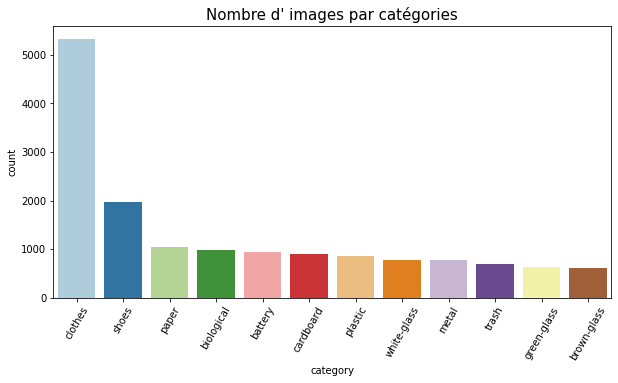

In [13]:
#Etudions la répartition des images par catégorie
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette = 'Paired', order = df['category'].value_counts().index)
plt.xticks(rotation=60)
plt.title('Nombre d\' images par catégories', fontsize=15)
plt.show()

Il faudra faire attention à bien rééquilibrer les catégories lors de notre mise 
en place du modèle car le modèle risque de trop bien apprendre sur les catégories vêtements et chaussures et de faire beaucoup d'erreurs sur les autres catégories

In [14]:
#PARTAGEONS LES IMAGES EN PLUSIEURS DATASETS - TRAIN - VALIDATION - TEST
from sklearn.model_selection import train_test_split

In [15]:
train_df, val_df = train_test_split(df, test_size=0.4, random_state=42)
len(train_df), len(val_df)



(9309, 6206)

In [16]:
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)
len(val_df), len(test_df)

(3103, 3103)

Nous avons donc un dataset d'entrainement de 60%, 20% images pour valider le modèle et 20% images pour le tester

In [17]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [18]:
len(train_df), len(val_df), len(test_df)

(9309, 3103, 3103)

# PREPROCESSING WITH IMAGE GENERATOR

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)
# Rescaling values from [0,255]->[0,1]


In [33]:
train_generator = train_data_gen.flow_from_dataframe(
    directory = "/content/drive/MyDrive/PROJET_FINAL/garbage_classification", # the folder where the class subfolders can be found
    dataframe = train_df,
    x_col='filename',
    y_col='category',
    target_size = (224,224), # The (height,width) of the produced images
    class_mode = "sparse", # Wether the target should be represented by an index or a dummy vector
    batch_size=32, # The batch size of the produced batches
    shuffle = True, #Whether to shuffle after all files have been selected once
    seed = 42
)

val_generator = val_data_gen.flow_from_dataframe(
    directory = "/content/drive/MyDrive/PROJET_FINAL/garbage_classification", # the folder where the class subfolders can be found
    dataframe = val_df,
    x_col= 'filename',
    y_col= 'category',
    target_size = (224,224), # The (height,width) of the produced images
    class_mode = "sparse", # Wether the target should be represented by an index or a dummy vector
    batch_size=32, # The batch size of the produced batches
    seed =42
)

test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    directory="/content/drive/MyDrive/PROJET_FINAL/garbage_classification",
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=42)


Found 9309 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.


In [21]:
#vérifions que les 3 datasets contiennent bien chacun les 12 classes correspondantes
nb_train_samples = train_generator.samples
classes_train = list(train_generator.class_indices.keys())
print('Classes: '+str(classes_train))
print(len(classes_train))

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
12


In [22]:
nb_validation_samples = val_generator.samples
classes_val = list(val_generator.class_indices.keys())
print('Classes: '+str(classes_val))
print(len(classes_val))

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
12


In [23]:
nb_test_samples = test_generator.samples
classes_test = list(test_generator.class_indices.keys())
print('Classes: '+str(classes_test))
print(len(classes_test))

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
12


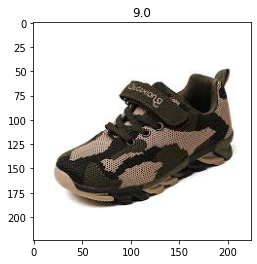

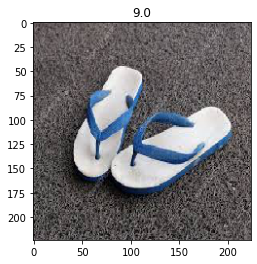

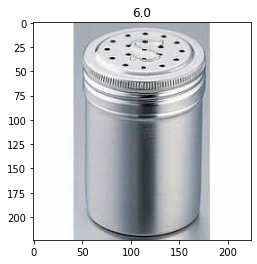

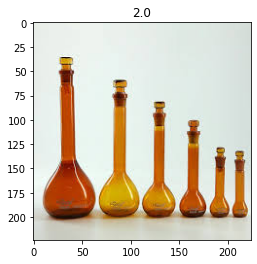

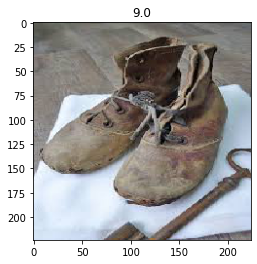

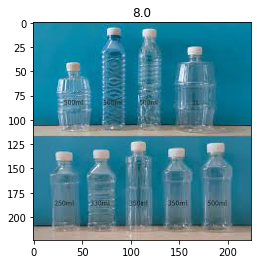

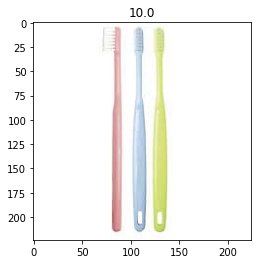

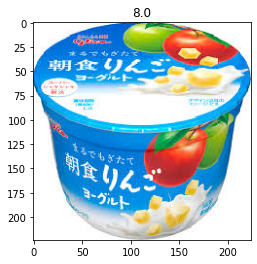

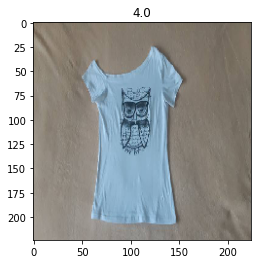

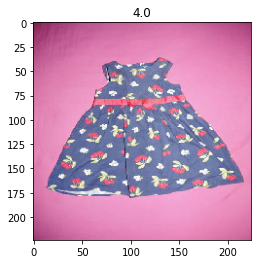

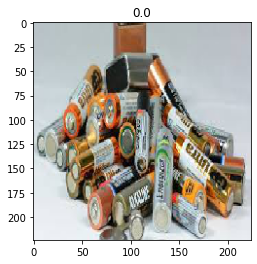

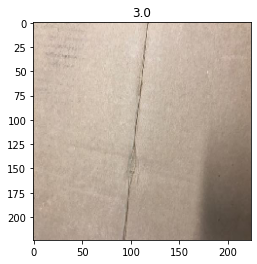

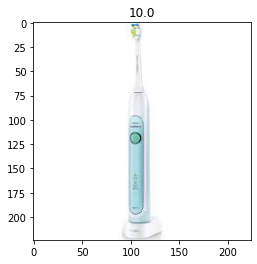

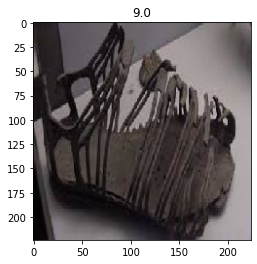

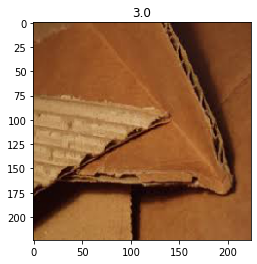

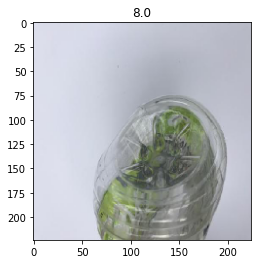

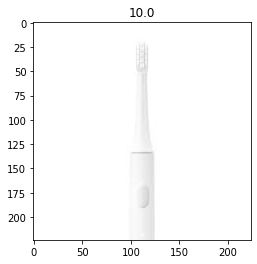

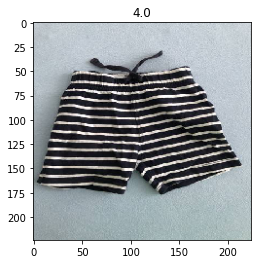

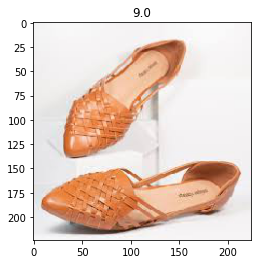

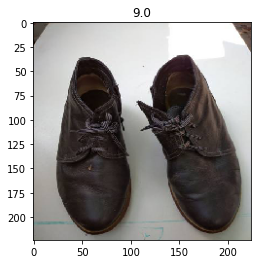

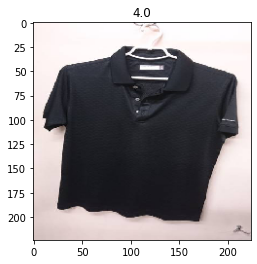

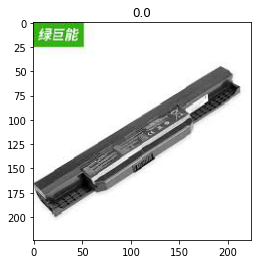

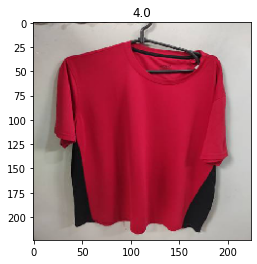

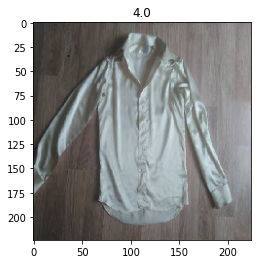

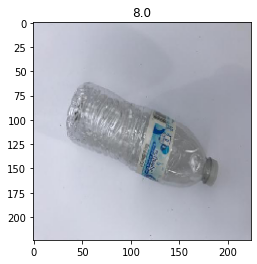

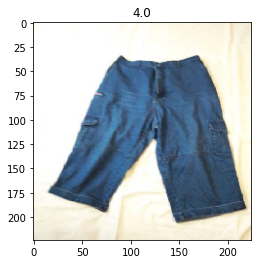

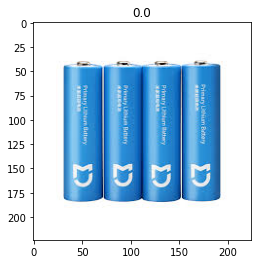

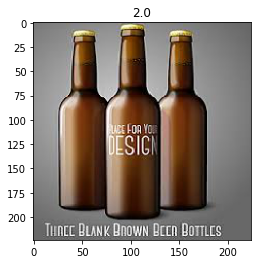

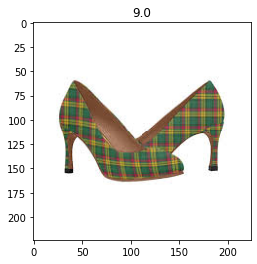

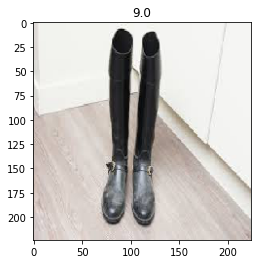

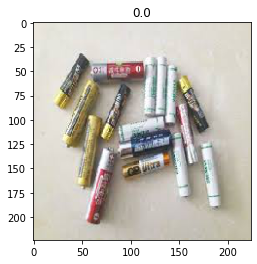

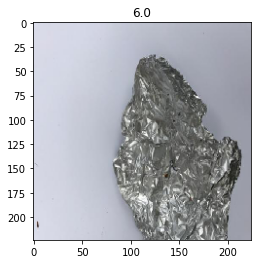

In [34]:
#regardons à quoi ressemblent les images que nous allons prédire
imgs, labels = next(iter(train_generator))
for img, label in zip(imgs, labels):
  plt.imshow(img)
  plt.title(label)
  plt.show()

CREATION D'UN RESEAU DE NEURONES CONVOLUTIONNEL

In [26]:
from tensorflow.keras.layers import Conv1D, Conv2D, Conv3D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential

In [35]:
imgs, targets = next(iter(train_generator))


model = Sequential(
    [
     Conv2D(16, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Flatten(),
     Dense(12, activation="softmax")
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 200704)            0         
                                                                 
 dense_2 (Dense)             (None, 12)                2408460   
                                                                 
Total params: 2,408,908
Trainable params: 2,408,908
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential(
    [
     Conv2D(16, (3,3), padding="same", input_shape=(224,224,3),
     MaxPool2D(),
     Flatten(),
     Dense(12, activation="softmax")
    ]
)

model.summary()

SyntaxError: ignored

A la fin nous voulons une couche de 12 réseaux de neurones puisque nous voulons classifier 12 classes de déchets

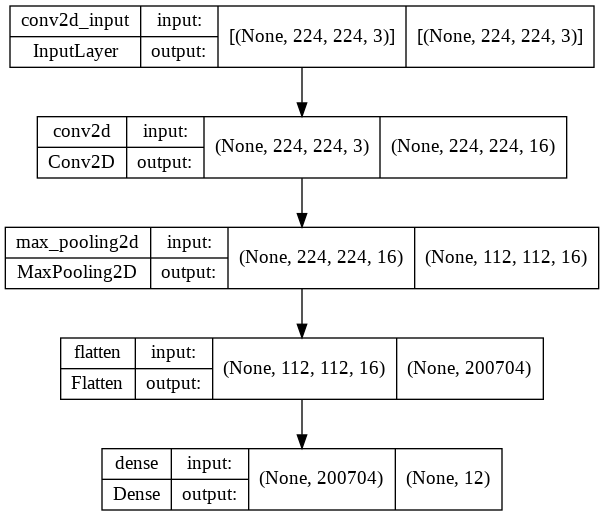

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [36]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [37]:
model.fit(train_generator, validation_data=val_generator, epochs=10)

Epoch 1/10
291/291 [==============================] - 3992s 14s/step - loss: 3.8818 - sparse_categorical_accuracy: 0.4736 - val_loss: 1.6351 - val_sparse_categorical_accuracy: 0.5530
Epoch 2/10
291/291 [==============================] - 57s 196ms/step - loss: 1.1356 - sparse_categorical_accuracy: 0.6552 - val_loss: 1.5758 - val_sparse_categorical_accuracy: 0.5582
Epoch 3/10
291/291 [==============================] - 52s 178ms/step - loss: 0.7101 - sparse_categorical_accuracy: 0.7828 - val_loss: 1.5434 - val_sparse_categorical_accuracy: 0.5588
Epoch 4/10
291/291 [==============================] - 52s 178ms/step - loss: 0.4340 - sparse_categorical_accuracy: 0.8747 - val_loss: 1.4554 - val_sparse_categorical_accuracy: 0.5859
Epoch 5/10
291/291 [==============================] - 51s 175ms/step - loss: 0.2799 - sparse_categorical_accuracy: 0.9332 - val_loss: 1.4919 - val_sparse_categorical_accuracy: 0.5807
Epoch 6/10
291/291 [==============================] - 51s 176ms/step - loss: 0.1891 -

Sur ce modèle nous obtenons une très mauvaise accuracy avec au mieux 59% d'images bien prédites. Le modèle se trompe pratiquement une fois sur 2

# TRANSFER LEARNING WITH INCEPTIONV3

Le modèle de TRANSFER LEARNING avec lequel nous avons obtenu le meilleur score est le modèle InceptionV3. Ce modèle est entraîné sur ImageNet, un ensemble de plus d'un million d'images. Le principe du Transfer Learning est d'utiliser un modèle qui a déjà été pré-entraîné, ici sur de nombreuses images, permettant ainsi d'obtenir une meilleure performance de prédiction.
Désavantage de ce modèle InceptionV3 : modèle assez lourd

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
#ici on va juste rajouter les 3 dernières couches du modèle afin d'indiquer ce qu'on veut prédire
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 2, 2, 2048)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 12)                98316     
                                                                 
Total params: 21,901,100
Trainable params: 98,316
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model.fit(train_generator, validation_data=val_generator, epochs=50)

Epoch 1/50
 14/291 [>.............................] - ETA: 2:02:34 - loss: 3.3363 - categorical_accuracy: 0.4688

KeyboardInterrupt: ignored

In [ ]:
model.save("/content/TransferLearningModel.h5")

In [ ]:
import json
# on va avoir l'historique de chaque métrique et loss de chaque époche
history_dict = model.history.history
# on enregistre sous formal json
json.dump(history_dict, open("/content/TransferLearningModelHistory.json", 'w'))

In [ ]:
history_dict = json.load(open("/content/TransferLearningModelHistory.json", 'r'))

In [ ]:
#on visualise l'accuracy
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

In [ ]:
#on visualise la loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

# FINE TUNING
Le principe du Fine Tuning est d'entraîner les dernières couches du modèle pour permettre d'affiner et aux dernières couches de mieux apprendre et donc mieux prédire. Ci-dessous on entraîne 10% des dernières couches du modèle + 3 dernières couches qu'on a rajouté précedemment pour le transfer learning

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

In [ ]:
len(base_model.layers)

311

In [ ]:
#on va entrainer 10% des dernières layers
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

In [ ]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 31
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 2, 2, 2048)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 12)                98316     
                                                                 
Total params: 21,901,100
Trainable params: 6,171,852
Non-trainable params: 15,729,248
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
#Equilibrons les différentes classes car nous avons vu que certaines catégories ont beaucoup plus d'élements que d'autres
#le modèle risque donc de très bien prédire les classes avec beaucoup de d'images car il aura très bien appris et pas assez les autres
#comptons le nombre de valeurs dans chaques classes:
np.unique(train_generator.classes, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 579,  597,  366,  490, 3187,  363,  460,  617,  538, 1216,  436,
         460]))

In [ ]:
#on crée un dataframe avec ces valeurs , l'index nous sert pour référencer les classes
import pandas as pd
d = {'count': [558,582,351,536,3201,373,447,627,543,1194,423,474]}
df = pd.DataFrame(data=d)
df

,count
0,558
1,582
2,351
3,536
4,3201
5,373
6,447
7,627
8,543
9,1194


In [ ]:
#On calcule l'inverse de chaque poids et on l'indique dans un dictionnaire, c'est le weights final qu'on appera dans le  model.fit
weights = 1/(df["count"]-1)
weights = weights * df['count'].sum()/12
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 1.3927289048473968,
 1: 1.3351979345955252,
 2: 2.216428571428571,
 3: 1.4500000000000002,
 4: 0.242421875,
 5: 2.0853494623655915,
 6: 1.7393497757847534,
 7: 1.239217252396166,
 8: 1.4312730627306272,
 9: 0.6502514668901928,
 10: 1.8382701421800949,
 11: 1.6400634249471457}

In [ ]:
model.fit(train_generator, validation_data=val_generator, epochs=10, class_weight= weights)

Epoch 1/10
291/291 [==============================] - 1790s 6s/step - loss: 0.6567 - categorical_accuracy: 0.8711 - val_loss: 0.2937 - val_categorical_accuracy: 0.9123
Epoch 2/10
291/291 [==============================] - 52s 177ms/step - loss: 0.0856 - categorical_accuracy: 0.9773 - val_loss: 0.3650 - val_categorical_accuracy: 0.9149
Epoch 3/10
291/291 [==============================] - 52s 177ms/step - loss: 0.0629 - categorical_accuracy: 0.9845 - val_loss: 0.3156 - val_categorical_accuracy: 0.9246
Epoch 4/10
291/291 [==============================] - 52s 177ms/step - loss: 0.0559 - categorical_accuracy: 0.9884 - val_loss: 0.5717 - val_categorical_accuracy: 0.9107
Epoch 5/10
291/291 [==============================] - 52s 177ms/step - loss: 0.0577 - categorical_accuracy: 0.9845 - val_loss: 0.3833 - val_categorical_accuracy: 0.9198
Epoch 6/10
291/291 [==============================] - 51s 176ms/step - loss: 0.0696 - categorical_accuracy: 0.9847 - val_loss: 0.4617 - val_categorical_accu

In [ ]:
model.save("content/model_final.h5")

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/ModelHistory.json", 'w'))

In [ ]:
history_dict = json.load(open("/content/ModelHistory.json", 'r'))

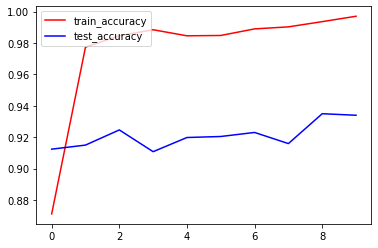

In [ ]:
# Visualise train / Valid Accuracy
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

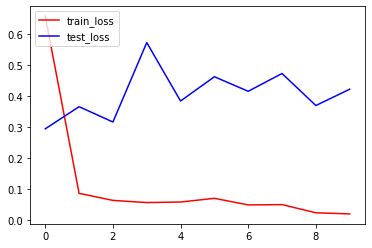

In [ ]:
# Visualise train / Valid Loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

Le modèle obtient une meilleure performance de prédiction (93% ) à 2 épochs, au delà le modèle commence à trop apprendre et n'arrive plus à généraliser sur des données qu'il n'a jamais vue auparavant

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/PROJET_GARBAGE_CLASSIFICATION/modele_final/10epochs-final/fineLearningModel_der_der10.h5")

In [ ]:
score = model.evaluate(val_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

97/97 [==============================] - 2589s 27s/step - loss: 0.1785 - categorical_accuracy: 0.9704
Val loss: 0.17851755023002625
Val accuracy: 0.9703512787818909


# EVALUATION DU MODELE SUR LES DONNEES TEST QUE LE MODELE N'A JAMAIS VU

In [ ]:
#prédiction des classes des images du jeu de données Test
Y_pred = model.predict(test_generator)

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
target_names = categories

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_generator.classes, y_pred)


In [ ]:
print(cm)

[[ 169    0    2    0    0    0    4    0    0    0    0    0]
 [   0  194    0    0    0    0    0    0    0    0    0    0]
 [   0    1  114    1    1    2    2    0    0    1    0    0]
 [   0    1    0  197    0    0    0    0    0    0    0    0]
 [   0    2    0    0 1089    0    0    1    0    5    5    0]
 [   0    1    7    0    0  108    1    0    1    0    0    2]
 [   1    1    0    1    1    0  163    0    0    1    0    1]
 [   2    3    1    1    1    0    3  203    2    0    1    0]
 [   0    0    1    0    0    3    2    3  141    0    0    5]
 [   0    1    0    0    0    0    0    0    0  370    1    0]
 [   0    0    0    0    1    0    0    1    0    1  130    0]
 [   1    0    0    0    0    0    2    0    4    0    0  139]]


In [ ]:
#création d'une fonction afin de mieux visualiser la matrice de confusion des prédictions
import itertools
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

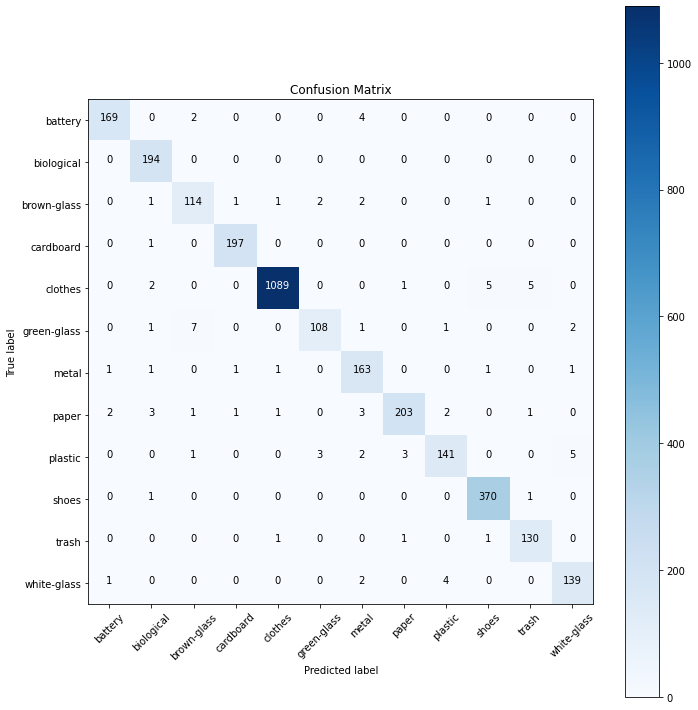

In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

Le nombre en diagonale est le nombre d'images bien prédit par catégorie, on peut identifier les erreurs de prédiction que le modèle a fait en dehors de cette diagonale

In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

     battery       0.98      0.97      0.97       175
  biological       0.95      1.00      0.97       194
 brown-glass       0.91      0.93      0.92       122
   cardboard       0.98      0.99      0.99       198
     clothes       1.00      0.99      0.99      1102
 green-glass       0.96      0.90      0.93       120
       metal       0.92      0.96      0.94       169
       paper       0.98      0.94      0.96       217
     plastic       0.95      0.91      0.93       155
       shoes       0.98      0.99      0.99       372
       trash       0.95      0.98      0.96       133
 white-glass       0.95      0.95      0.95       146

    accuracy                           0.97      3103
   macro avg       0.96      0.96      0.96      3103
weighted avg       0.97      0.97      0.97      3103



On étudie aussi le f1-score qui permet de vérifier que le bon score obtenu au global est bien réparti entre les catégories et qu'il n'y a pas des catégories qui restent mal prédites

In [ ]:
# Using the test dataset
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3103/3103 [==============================] - 49s 16ms/step - loss: 0.1823 - categorical_accuracy: 0.9723
Test loss: 0.1823166161775589
Test accuracy: 0.9722849130630493


TESTONS LA PREDICTION D'UNE IMAGE GRACE A NOTRE MODELE AVANT DE LE METTRE EN PRODUCTION

In [ ]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

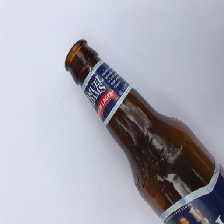

In [ ]:
image = load_img('/content/drive/MyDrive/PROJET_FINAL/garbage_classification/brown-glass/brown-glass277.jpg', target_size=(224,224,3))
image

In [ ]:
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image=image/255


In [ ]:
#on prédit
prediction = model.predict(image)


In [ ]:
prediction

array([[2.1215344e-07, 3.4181475e-09, 9.9996209e-01, 1.6133556e-10,
        2.0923800e-08, 7.0213041e-06, 1.6573398e-06, 1.2554220e-09,
        2.6508209e-05, 2.8528140e-07, 1.4049150e-09, 2.1774561e-06]],
      dtype=float32)

In [ ]:
#on récupere la catégorie associée qui a obtenu le meilleur score
categorie = np.argmax(prediction,axis=1)

print(categorie)

[2]


Le modèle prédit la catégorie 2 qui correspond à la catégorie "brown-glass", la catégorie 0 correspond à la catégorie "battery".

In [ ]:
#images classées en 12 catégories
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

REGARDONS DE PLUS PRES LES IMAGES TEST QUI ONT ETE MAL PREDITES

In [ ]:
#on crée un dataframe Dataset_test
dataset_test=test_df

In [ ]:
#on vérifie les catégories prédites par le modèle et on l'insère dans le dataframe_test pour comparaison
categorie_predite =np.argmax(Y_pred,axis=1)
dataset_test['num_cat']= pd.DataFrame(categorie_predite)

In [ ]:
dataset_test.head()

,filename,category,num_cat
0,clothes/clothes1119.jpg,clothes,4
1,clothes/clothes3976.jpg,clothes,4
2,clothes/clothes298.jpg,clothes,4
3,metal/metal749.jpg,metal,6
4,clothes/clothes486.jpg,clothes,4


In [ ]:
#on crée un dictionnaire pour identifier les classes
gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [ ]:
#on spécifie un dataframe "label" 
label_df=pd.DataFrame.from_dict(gen_label_map,orient='index')
label_df=label_df.rename(columns = {0: 'categorie_predite'})

In [ ]:
label_df['num_cat']=[0,1,2,3,4,5,6,7,8,9,10,11]

In [ ]:
label_df

,categorie_predite,num_cat
0,battery,0
1,biological,1
2,brown-glass,2
3,cardboard,3
4,clothes,4
5,green-glass,5
6,metal,6
7,paper,7
8,plastic,8
9,shoes,9


In [ ]:
#on joint le Dataset_test avec le label_df pour avoir le nom de la catégorie prédite
join = pd.merge(dataset_test, 
                      label_df, 
                      on ='num_cat', 
                      how ='left')

In [ ]:
join.head()

,filename,category,num_cat,categorie_predite
0,clothes/clothes1119.jpg,clothes,4,clothes
1,clothes/clothes3976.jpg,clothes,4,clothes
2,clothes/clothes298.jpg,clothes,4,clothes
3,metal/metal749.jpg,metal,6,metal
4,clothes/clothes486.jpg,clothes,4,clothes


In [ ]:
#on souhaite ici trouver les images qui ont été mal prédites
df_mask=join['category']!= join['categorie_predite']
filtered_df = join[df_mask]
filtered_df

,filename,category,num_cat,categorie_predite
29,white-glass/white-glass3.jpg,white-glass,8,plastic
37,paper/paper890.jpg,paper,10,trash
39,plastic/plastic679.jpg,plastic,11,white-glass
58,green-glass/green-glass114.jpg,green-glass,8,plastic
70,green-glass/green-glass606.jpg,green-glass,2,brown-glass
...,...,...,...,...
2852,plastic/plastic339.jpg,plastic,7,paper
2885,brown-glass/brown-glass32.jpg,brown-glass,4,clothes
2993,green-glass/green-glass317.jpg,green-glass,2,brown-glass
2994,plastic/plastic249.jpg,plastic,6,metal


In [ ]:
#filtrons sur la catégori "Green-glass" pour voir avec quelles autres catégories le modèle a confondu
filtered_glass=filtered_df[filtered_df['category']=='green-glass']


In [ ]:
filtered_glass

,filename,category,num_cat,categorie_predite
58,green-glass/green-glass114.jpg,green-glass,8,plastic
70,green-glass/green-glass606.jpg,green-glass,2,brown-glass
681,green-glass/green-glass179.jpg,green-glass,11,white-glass
894,green-glass/green-glass61.jpg,green-glass,6,metal
1101,green-glass/green-glass45.jpg,green-glass,2,brown-glass
1162,green-glass/green-glass71.jpg,green-glass,11,white-glass
1414,green-glass/green-glass161.jpg,green-glass,2,brown-glass
1505,green-glass/green-glass241.jpg,green-glass,2,brown-glass
1803,green-glass/green-glass609.jpg,green-glass,1,biological
1970,green-glass/green-glass321.jpg,green-glass,2,brown-glass
